In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import pickle as pkl
import corner
from scipy.stats import uniform, multivariate_normal, norm, gamma

### Problem 1: Go back to the 11th data set (the last data set) from Problem 2 of Problem Set 2 and sample in the 6-dimensional space (5 linear amplitudes and the period T) with some sensible priors on all 6 parameters (we’ll discuss possible priors in class). Make a “corner plot” of the posterior sampling, and plot a sampling of 16 independent samples from the posterior in the space of the data, on the data.


The model is $y(x) = A_1\cos(\omega_1 x)+A_2\sin(\omega_1 x)+ B_1\cos(\omega_2 x)+B_2\sin(\omega_2 x)$
where $\omega_1 = \frac{2\pi}{100}$ and the parameters $A_1, A_2, B_1, B_2, \omega_2$ are free. Like in the previous homeworks, I am subtracting off the mean of the signal because that is common practice in signal processing and you can get rid of some dimensions by doing so. So instead of the stated 6 dimensions, I only have 5 dimensions!

Note that frequency should not be negative here, but the amplitudes can be negative. So appropriate priors could be $\omega_2 \in \Gamma[1,1]$, and all the amplitudes in $N[0, 5]$  

In [2]:
#load in the data
with open("data.pkl", "rb") as handle:
    data = pkl.load(handle).T # check out that pesky little `.T`
print(data.shape)

xs = data[0, :]
yerrs = data[1, :]
ys = data[12, :] - np.mean(data[12, :])

(13, 1024)


In [3]:
def log_prior(thetas_prime): 
    theta1, theta2, theta3, theta4, theta5 = thetas_prime
    omega2 = gamma(1,1) #start, width
    A1 = norm(0,5) #start, width
    A2 = norm(0,5)#start, width
    B1 = norm(0,5)#start, width
    B2 = norm(0,5)#start, width
    prior = \
      omega2.pdf(theta1)*A1.pdf(theta2)*A2.pdf(theta3)*B1.pdf(theta4)*B2.pdf(theta5)
    return np.log(prior)

In [4]:
def model(x, omega2, A1, A2, B1, B2):
    omega1 = 2*np.pi/100
    func = A1*np.cos(omega1*x)+A2*np.sin(omega1*x)+B1*np.cos(omega2*x)+\
            B2*np.sin(omega2*x)
    return func

In [5]:
def log_likelihood(params, xs, ys, yerrs):
    C_inv = 1/yerrs**2
    yhats = model(xs, *params)
    residuals = (ys-yhats)
    arr = -0.5*C_inv**2*residuals**2
    ll = np.sum(arr)
    return ll

First I will verify my MCMC by giving it a very easy fit with no noise to do. The MCMC seems to work as expected.

In [6]:
fake_ys = model(xs, 1, 5, 0, 0, 0)

In [7]:
N = 10000
thetas_list = []
thetas = np.zeros(5)
times = [0]
i = 0
while i<N:
    thetas_prime = multivariate_normal(thetas, 2*np.identity(5)).rvs()
    r = np.random.uniform() 
    proposal = log_prior(thetas_prime)+log_likelihood(thetas_prime, xs, fake_ys, yerrs)
    previous = log_prior(thetas)+log_likelihood(thetas, xs, fake_ys, yerrs)
    g= np.min((np.exp(proposal-previous),1))
    if g>r:
        thetas = thetas_prime
    thetas_list.append(thetas)
    i += 1
    times.append(i)

<ipython-input-3-9d529ea574b1>:10: RuntimeWarning: divide by zero encountered in log
  return np.log(prior)
<ipython-input-7-08734f0f5797>:11: RuntimeWarning: invalid value encountered in double_scalars
  g= np.min((np.exp(proposal-previous),1))
<ipython-input-7-08734f0f5797>:11: RuntimeWarning: overflow encountered in exp
  g= np.min((np.exp(proposal-previous),1))


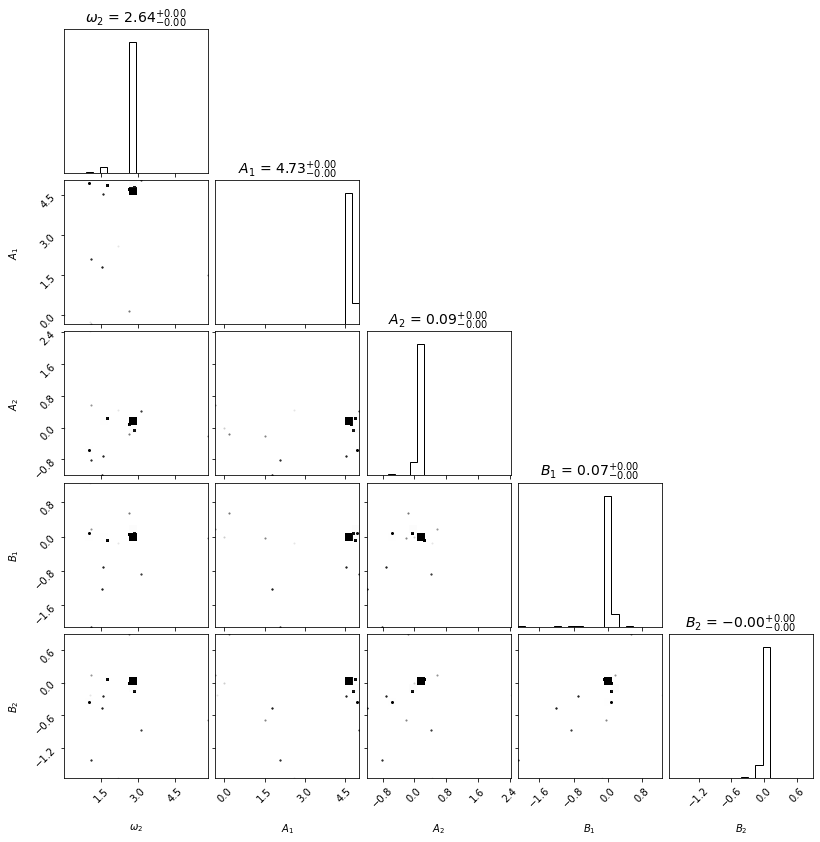

In [8]:
samples = np.vstack(thetas_list)
nsamples, ndim = samples.shape
figure = corner.corner(
    samples,
    labels=[
        r"$\omega_2$",
        r"$A_1$",
        r"$A_2$",
        r"$B_1$",
        r"$B_2$",
    ],
    show_titles=True,
    title_kwargs={"fontsize": 14},
)


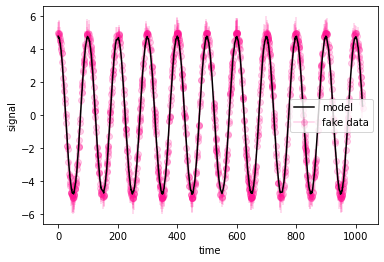

In [9]:
params = np.mean(samples, axis = 0)

plt.plot(xs, model(xs, *params), color = 'black', zorder = 1, label = 'model')
plt.errorbar(xs, fake_ys, yerr = yerrs, marker = 'o',color = 'deeppink', alpha = 0.2, zorder = 0, label = 'fake data')
plt.ylabel('signal')
plt.xlabel('time')
plt.legend()

Now to do the fit on the real data. Note that the computer I'm writing this on isn't great so I'm doing way less steps than I should.

In [10]:
N = 10000
thetas_list = []
thetas = np.zeros(5)
times = [0]
i = 0
while i<N:
    thetas_prime = multivariate_normal(thetas, np.identity(5)).rvs()
    r = np.random.uniform() 
    proposal = log_prior(thetas_prime)+log_likelihood(thetas_prime, xs, ys, yerrs)
    previous = log_prior(thetas)+log_likelihood(thetas, xs, ys, yerrs)
    g= np.min((np.exp(proposal-previous),1))
    if g>r:
        thetas = thetas_prime
    thetas_list.append(thetas)
    i += 1
    times.append(i)
samples = np.vstack(thetas_list)

<ipython-input-3-9d529ea574b1>:10: RuntimeWarning: divide by zero encountered in log
  return np.log(prior)
<ipython-input-10-38f101aa8e6e>:11: RuntimeWarning: invalid value encountered in double_scalars
  g= np.min((np.exp(proposal-previous),1))
<ipython-input-10-38f101aa8e6e>:11: RuntimeWarning: overflow encountered in exp
  g= np.min((np.exp(proposal-previous),1))


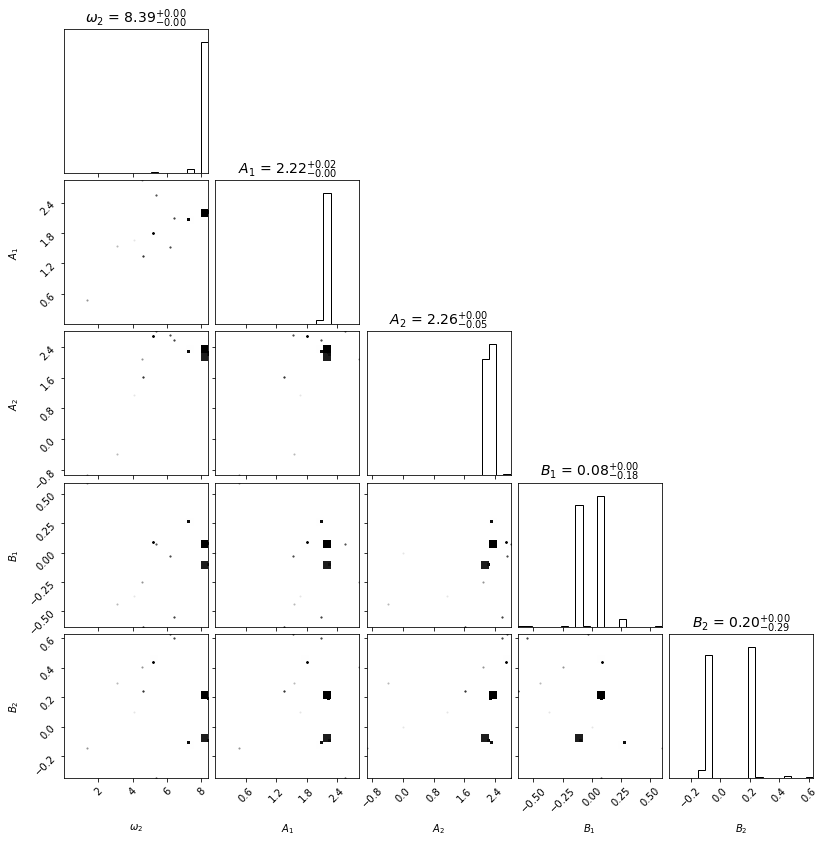

In [11]:
nsamples, ndim = samples.shape
figure = corner.corner(
    samples,
    labels=[
        r"$\omega_2$",
        r"$A_1$",
        r"$A_2$",
        r"$B_1$",
        r"$B_2$",
    ],
    show_titles=True,
    title_kwargs={"fontsize": 14},
)
params = np.mean(samples, axis = 0)

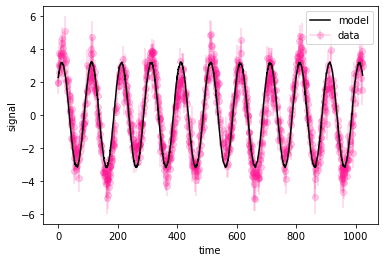

In [12]:
plt.plot(xs, model(xs, *params), color = 'black', zorder = 1, label = 'model')
plt.errorbar(xs, ys, yerr = yerrs, marker = 'o',color = 'deeppink', alpha = 0.2, zorder = 0, label = 'data')
plt.ylabel('signal')
plt.xlabel('time')
plt.legend()

### Problem 2: Go back to the 10th data set (the second-last data set) from Problem 2 of Problem Set 2, and plot the residuals (data minus best-fit model expectation) away from the one-period (100-day-period) model, but folded at the period of the putative best-fit period T for the 11th data set (the last data set). Is it believable? That is, check the model, visually.

This does not look like a believable signal frequency, it is much too fast.

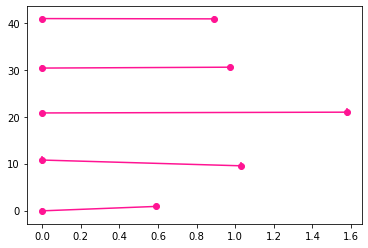

In [13]:
xs = data[0, :]
yerrs = data[1, :]
ys2 = data[11, :] - np.mean(data[11, :])
omega_2 = params[0]

T2 = 2*np.pi/omega_2
wh = (np.where(xs>T2))[0][0]

for i in range(5):
    plt.errorbar(xs[wh*i:wh*(i+1)]-xs[wh*i], ys2[wh*i:wh*(i+1)]+10*i, \
                 yerr = yerrs[wh*i:wh*(i+1)], marker = 'o', color = 'deeppink')

### Problem 3: Re-do problem 2 of Problem Set 2 using K-fold cross-validation with K=8. That is, fit the 1- and 2-period models to all but one eighth of each data set and predict the held-out eighth, and repeat for all eight held-out eighths, for all 11 data sets. Which is a better model in each case? Now compute the AIC and BIC instead. Which is a better model according to these? Make a table, maybe?

K-fold validation proceeds as follows:
Break the data into 8 sections, then do the model training on all but one of these sections. Repeat this, leaving out a different section each time. Then test each model on each left out section.

In [14]:
def model2_fit(data_xs, data_ys, data_sigma_ys, omegas):
    """does fit to model described in text above, returns parameters, their errors, and negative log likelihood""" 
    omega1, omega2 = omegas
    X = np.vstack((np.cos(omega1*data_xs), np.sin(omega1*data_xs), np.cos(omega2*data_xs), np.sin(omega2*data_xs))).T
    Y = np.expand_dims(data_ys, 1)
    C_inv = np.zeros((len(data_xs), len(data_xs)))
    np.fill_diagonal(C_inv, 1/data_sigma_ys**2)
    A = (X.T@C_inv)@X
    B = (X.T@C_inv)@Y

    #solve
    Z = linalg.solve(A, B)

    #fit variance
    A = (X.T@C_inv)@X
    B = np.identity(A.shape[0])
    Z_var = linalg.solve(A, B)
    
    #$\mathcal{L} = -\frac{1}{2}(Y-X\theta)^TC^{-1}(Y-X\theta)$
    ll = -0.5*(Y-X@Z).T@C_inv@(Y-X@Z)
    
    
    #unpack data
    A1 = Z[0][0]
    A1_err = np.sqrt(Z_var[0][0])  
    A2 = Z[1][0]
    A2_err = np.sqrt(Z_var[1][1])
    B1 = Z[2][0]
    B1_err = np.sqrt(Z_var[2][2])  
    B2 = Z[3][0]
    B2_err = np.sqrt(Z_var[3][3])
    #print(f'The uncertainty variance of the amplitude is {C1_err**2}')
    return A1, A1_err, A2, A2_err, B1, B1_err, B2, B2_err, -ll[0][0]

In [15]:
def model2(x, A1, A2, B1, B2, omega1, omega2):
    func = A1*np.cos(omega1*x)+A2*np.sin(omega1*x)+B1*np.cos(omega2*x)+\
            B2*np.sin(omega2*x)
    return func

In [16]:
def model1(x, C1, C2):
    omega = 2*np.pi/100
    return C1*np.cos(omega*x)+C2*np.sin(omega*x)

def model1_fit(data_xs, data_ys, data_sigma_ys):
    omega = 2*np.pi/100
    X = np.vstack((np.cos(omega*data_xs), np.sin(omega*data_xs))).T
    Y = np.expand_dims(data_ys, 1)
    C_inv = np.zeros((len(data_xs), len(data_xs)))
    np.fill_diagonal(C_inv, 1/data_sigma_ys**2)
    A = (X.T@C_inv)@X
    B = (X.T@C_inv)@Y

    #solve
    Z = linalg.solve(A, B)

    #fit variance
    A = (X.T@C_inv)@X
    B = np.identity(A.shape[0])
    Z_var = linalg.solve(A, B)
    
    #unpack data
    C1 = Z[0][0]
    C1_err = np.sqrt(Z_var[0][0])  
    C2 = Z[1][0]
    C2_err = np.sqrt(Z_var[1][1])
    #print(f'The uncertainty variance of the amplitude is {C1_err**2}')
    return C1, C2

In [17]:
def fit_all_model1(data):   
    params_list = []
    for i in range(2, 13):
        ys = data[i, :] - np.mean(data[i, :])
        xs = data[0, :]
        yerrs = data[1, :]
        params = model1_fit(xs, ys, yerrs)
        params_list.append(params)
    return params_list

In [18]:
def profile(omega_2s, xs, ys, yerrs):   
    #do the profiling
    omega_1 = 2*np.pi/100
    nlls = []
    A1s = []
    A2s = []
    B1s = []
    B2s = []

    for omega_2 in omega_2s:
        omegas = [omega_1, omega_2]
        A1, A1_err, A2, A2_err, B1, B1_err, B2, B2_err, nll = model2_fit(xs, ys, yerrs, omegas)
        params = [A1, A2, B1, B2]
        A1s.append(A1)
        A2s.append(A2)
        B1s.append(B1)
        B2s.append(B2)
        nlls.append(nll)
    #fig, ax = plt.subplots()
    #plot chi squared vs desired parameter omega_2
    #plt.semilogy(omega_2s,nlls)
    #plt.ylabel(r'$\frac{\chi^2}{2}$', fontsize = 20)
    #plt.xlabel(r'$\omega_2$', fontsize = 14)
    omega_2 = (omega_2s[np.where(nlls == np.min(nlls))])[0]
    return omega_2, A1, A2, B1, B2

In [19]:
def fit_all_model2(data):   
    params_list = []
    for i in range(2, 13):
        ys = data[i, :] - np.mean(data[i, :])
        xs = data[0, :]
        yerrs = data[1, :]
        omega_2s = np.linspace(0.01, 1, 1000)
        params = profile(omega_2s, xs, ys, yerrs)
        params_list.append(params)
    return params_list

In [20]:
all_errors_model2 = []
N = data.shape[1]
indices = np.arange(N)
np.random.shuffle(indices)
groups = np.split(indices,8)
for i in range(1,7):
    newindices1 = np.hstack(groups[0:i])
    newindices2 = np.hstack(groups[i+1:8])
    trainindices = np.hstack((newindices1, newindices2))
    datatrain = data[:,trainindices]
    valindices = groups[i]
    dataval = data[:,valindices]
    omegas_train = fit_all_model2(datatrain)
    omega1 = 2*np.pi/100
    errors = []
    for j in range(2, 13):
        omega2, A1, A2, B1, B2 = omegas_train[j-2]
        xsval = dataval[0, :]
        yerrsval = dataval[1, :]
        error = np.mean(np.abs(dataval[j,:] - model2(xsval, A1, A2, B1, B2, omega1, omega2)))
        errors.append(error)
    errors = np.array(errors)
    all_errors_model2.append(errors)
err_mean_model2 = np.mean(np.vstack(all_errors_model2), axis=0)
err_std_model2 = np.std(np.vstack(all_errors_model2), axis=0)

In [21]:
all_errors_model1 = []
for i in range(1,7):
    newindices1 = np.hstack(groups[0:i])
    newindices2 = np.hstack(groups[i+1:8])
    trainindices = np.hstack((newindices1, newindices2))
    datatrain = data[:,trainindices]
    valindices = groups[i]
    dataval = data[:,valindices]
    omegas_train = fit_all_model1(datatrain)
    errors = []
    for j in range(2, 13):
        C1, C2 = omegas_train[j-2]
        xsval = dataval[0, :]
        yerrsval = dataval[1, :]
        error = np.mean(np.abs(dataval[j,:] - model1(xsval, C1, C2)))
        errors.append(error)
    errors = np.array(errors)
    all_errors_model1.append(errors)
err_mean_model1 = np.mean(np.vstack(all_errors_model1), axis=0)
err_std_model1 = np.std(np.vstack(all_errors_model1), axis=0)

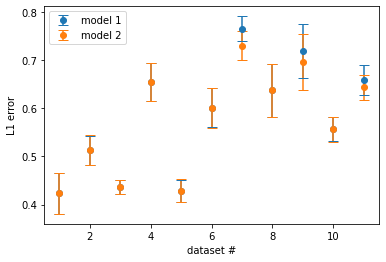

In [22]:
plt.errorbar(np.arange(1,len(err_mean_model1)+1), err_mean_model1, yerr = err_std_model1,\
             linestyle = 'None', capsize = 5, marker = 'o', label = 'model 1')
plt.errorbar(np.arange(1,len(err_mean_model2)+1), err_mean_model2, yerr = err_std_model2,\
             linestyle = 'None', capsize = 5, marker = 'o', label = 'model 2')
plt.ylabel('L1 error')
plt.xlabel('dataset #')
plt.legend()

It looks like model 2 is marginally better than model 1.

The AIC is defined as
$\mathrm {AIC} \,=\,2k-2\ln({\hat {L}})$
where $k$ is the number of free parameters and $\hat{L}$ is the likelihood. The better model is the one where the AIC is minimized.

In [23]:
def neg_log_likelihood_model2( xs, ys, yerrs, A1, A2, B1, B2, omega1, omega2):
    C_inv = 1/yerrs**2
    yhats = model2(xs, A1, A2, B1, B2, omega1, omega2)
    residuals = (ys-yhats)
    arr = -0.5*C_inv**2*residuals**2
    ll = np.sum(arr)
    return -ll

In [24]:
def neg_log_likelihood_model1( xs, ys, yerrs, C1,C2):
    C_inv = 1/yerrs**2
    yhats = model1(xs,C1, C2)
    residuals = (ys-yhats)
    arr = -0.5*C_inv**2*residuals**2
    ll = np.sum(arr)
    return -ll

In [25]:
xs = data[0, :]
yerrs = data[1, :]
omegas = fit_all_model2(data)
omega1 = 2*np.pi/100
AICs_model2 = []
for j in range(2, 13):
    omega2, A1, A2, B1, B2 = omegas[j-2]
    nll = neg_log_likelihood_model2( xs, ys, yerrs, A1, A2, B1, B2, omega1, omega2)
    AIC = 2*6+2*nll
    AICs_model2.append(AIC)

In [26]:
xs = data[0, :]
yerrs = data[1, :]
omegas = fit_all_model1(data)
AICs_model1 = []
for j in range(2, 13):
    C1, C2 = omegas[j-2]
    nll = neg_log_likelihood_model1( xs, ys, yerrs, C1, C2)
    AIC = 2*2+2*nll
    AICs_model1.append(AIC)

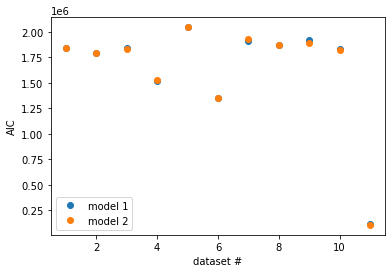

In [27]:
plt.plot(np.arange(1,len(err_mean_model1)+1), AICs_model1, label = 'model 1', marker = 'o', linestyle = 'None')
plt.plot(np.arange(1,len(err_mean_model2)+1), AICs_model2, label = 'model 2', marker = 'o', linestyle = 'None')
plt.ylabel('AIC')
plt.xlabel('dataset #')
plt.legend()

It looks like model 2 is marginally better than model 1.

$\mathrm {BIC} =k\ln(n)-2\ln({\widehat {L}})$ where $n$ is the number of data points in the time seris, $k$ is the number of free parameters and $\hat{L}$ is the likelihood

In [28]:
xs = data[0, :]
yerrs = data[1, :]
omegas = fit_all_model2(data)
omega1 = 2*np.pi/100
BICs_model2 = []
for j in range(2, 13):
    omega2, A1, A2, B1, B2 = omegas[j-2]
    nll = neg_log_likelihood_model2( xs, ys, yerrs, A1, A2, B1, B2, omega1, omega2)
    BIC = 6*np.log(len(xs))+2*nll
    BICs_model2.append(BIC)

In [29]:
xs = data[0, :]
yerrs = data[1, :]
omegas = fit_all_model1(data)
BICs_model1 = []
for j in range(2, 13):
    C1, C2 = omegas[j-2]
    nll = neg_log_likelihood_model1( xs, ys, yerrs, C1, C2)
    BIC =  2*np.log(len(xs))+2*nll
    BICs_model1.append(BIC)

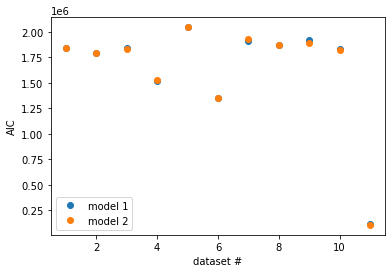

In [30]:
plt.plot(np.arange(1,len(err_mean_model1)+1), BICs_model1, label = 'model 1', marker = 'o', linestyle = 'None')
plt.plot(np.arange(1,len(err_mean_model2)+1), BICs_model2, label = 'model 2', marker = 'o', linestyle = 'None')
plt.ylabel('AIC')
plt.xlabel('dataset #')
plt.legend()

It looks like model 2 is marginally better than model 1. The better model is the one where the BIC is minimized.